<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_NET_with_VOC_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision.transforms.functional as TVF
import glob

# 문제 발생 시 CUDA 동기적으로 에러 출력
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [16]:
# 데이터셋 다운로드 및 압축 해제
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

# COLOR_2_INDEX 및 CLASS_NAMES 정의 (PASCAL VOC 2012)
COLOR_2_INDEX = {
    (0, 0, 0): 0,            # Background
    (128, 0, 0): 1,          # Aeroplane
    (0, 128, 0): 2,          # Bicycle
    (128, 128, 0): 3,        # Bird
    (0, 0, 128): 4,          # Boat
    (128, 0, 128): 5,        # Bottle
    (0, 128, 128): 6,        # Bus
    (128, 128, 128): 7,      # Car
    (64, 0, 0): 8,           # Cat
    (192, 0, 0): 9,          # Chair
    (64, 128, 0): 10,        # Cow
    (192, 128, 0): 11,       # Dining Table
    (64, 0, 128): 12,        # Dog
    (192, 0, 128): 13,       # Horse
    (64, 128, 128): 14,      # Motorbike
    (192, 128, 128): 15,     # Person
    (0, 64, 0): 16,          # Potted Plant
    (128, 64, 0): 17,        # Sheep
    (0, 192, 0): 18,         # Sofa
    (128, 192, 0): 19,       # Train
    (0, 64, 128): 20         # TV/Monitor
}
CLASS_NAMES = ["Background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow",
               "Dining Table", "Dog", "Horse", "Motorbike", "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV/Monitor"]

In [17]:
class PascalVoc(Dataset):
    def __init__(self, path, img_size, device="cuda"):
        # 초기화 함수로 데이터셋 경로, 이미지 크기, 사용할 장치를 설정한다.
        self.seg_folder = "SegmentationClass/"  # SegmentationClass 폴더 경로
        self.img_folder = "JPEGImages/"  # JPEGImages 폴더 경로
        self.path = path  # 데이터셋의 기본 경로
        self.device = device  # 사용할 장치(CUDA 또는 CPU)

        # SegmentationClass 폴더 내의 모든 이미지 경로를 가져온다.
        self.segmentation_imgs = glob.glob(os.path.join(path, self.seg_folder, "*"))
        self.img_size = img_size  # 이미지 크기 설정

    def __len__(self):
        # 데이터셋의 전체 샘플 수를 반환한다.
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        # 주어진 인덱스에 해당하는 이미지와 마스크 경로를 반환한다.
        mask_path = self.segmentation_imgs[idx]  # 인덱스에 해당하는 마스크 이미지 경로

        # 마스크 이미지 파일 이름을 가져온다.
        file_name = mask_path.split("/")[-1]
        # JPEGImages 폴더에서 해당하는 원본 이미지 경로를 만든다.
        img_path = os.path.join(self.path, self.img_folder, file_name.split(".")[0] + ".jpg")

        # 원본 이미지 경로와 마스크 이미지 경로를 튜플로 반환한다.
        return (img_path, mask_path)

    def load_imgs(self, idx):
        # 주어진 인덱스에 해당하는 원본 이미지와 마스크 이미지를 로드하여 반환한다.
        img_path, mask_path = self.get_paths(idx)  # 인덱스에 해당하는 이미지와 마스크 경로를 가져온다.

        # 원본 이미지를 로드하고, 지정된 크기로 리사이즈한다.
        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))

        # 마스크 이미지를 로드하고, RGB로 변환한 후 지정된 크기로 리사이즈한다.
        mask_img = Image.open(mask_path).convert("RGB")
        mask_img = mask_img.resize((self.img_size, self.img_size))

        # 원본 이미지와 마스크 이미지를 튜플로 반환한다.
        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        # 마스크 이미지를 정수형 NumPy 배열로 변환하고, 레이블 마스크를 생성한다.
        mask = np.array(mask_img).astype(int)  # 마스크 이미지를 NumPy 배열로 변환
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)  # 빈 레이블 마스크 초기화

        # COLOR_2_INDEX에 따라 마스크 이미지의 각 픽셀에 레이블을 할당한다.
        for idx, label in enumerate(COLOR_2_INDEX):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)  # 레이블 마스크를 정수형으로 변환
        return label_mask  # 레이블 마스크 반환

    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터를 반환하는 함수로, 데이터 증강을 포함한다.
        img, mask_img = self.load_imgs(idx)  # 이미지와 마스크를 로드한다.

        # 랜덤으로 이미지를 좌우 반전시킨다 (데이터 증강).
        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)

        # 마스크 이미지를 레이블 마스크로 변환하고, 텐서로 변환한다.
        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()

        # 이미지를 텐서로 변환하고, 정규화한다.
        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)
                           )

        # 이미지와 마스크를 지정된 장치로 이동시킨다.
        img = img.to(self.device)
        mask_img = mask_img.to(self.device)

        # 이미지와 마스크를 튜플로 반환한다.
        return (img, mask_img)

In [18]:
# 2D 합성곱(convolution)과 배치 정규화(batch normalization) 레이어를 정의하는 클래스
class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 2D 합성곱 레이어를 정의한다.
        # 입력 채널 수(in_channels)에서 출력 채널 수(out_channels)로 변환하며,
        # 커널 크기는 3x3, 스트라이드는 1, 패딩은 1로 설정되어 있다.
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # 배치 정규화 레이어를 정의한다. 출력 채널 수를 기준으로 배치 정규화를 수행한다.
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 입력 데이터 x에 대해 합성곱 연산을 수행한다.
        x = self.conv(x)

        # ReLU 활성화 함수를 적용하여 비선형성을 추가한다.
        x = F.relu(x)

        # 배치 정규화를 수행하여 데이터의 분포를 정규화한다.
        x = self.bn(x)

        # 최종 결과를 반환한다.
        return x

# 2D 전치 합성곱(transposed convolution)과 배치 정규화 레이어를 정의하는 클래스
class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 2D 전치 합성곱 레이어를 정의한다.
        # 전치 합성곱은 일반 합성곱의 반대 방향으로 작동하며, 보통 업샘플링(upsampling)에 사용된다.
        # 입력 채널 수(in_channels)에서 출력 채널 수(out_channels)로 변환하며,
        # 커널 크기는 3x3, 스트라이드는 2, 패딩은 1, 출력 패딩은 1로 설정되어 있다.
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

        # 배치 정규화 레이어를 정의한다. 출력 채널 수를 기준으로 배치 정규화를 수행한다.
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 입력 데이터 x에 대해 전치 합성곱 연산을 수행한다.
        x = self.conv(x)

        # ReLU 활성화 함수를 적용하여 비선형성을 추가한다.
        x = F.relu(x)

        # 배치 정규화를 수행하여 데이터의 분포를 정규화한다.
        x = self.bn(x)

        # 최종 결과를 반환한다.
        return x

In [19]:
class u_net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # U-Net의 출력 클래스 수를 정의한다.
        self.num_classes = num_classes

        # U-Net에서 사용할 VGG 블록의 인덱스를 정의한다.
        self.un_block_indicies = [(0, 4), (5, 9), (10, 16),
                                   (17, 23), (24, 30)]

        # VGG16 모델 초기화를 위한 메서드 호출
        self.init_vgg()

        # U-Net의 중간 레이어에 사용할 2개의 7x7 컨볼루션 레이어를 정의한다.
        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)

        # 업샘플링을 위한 전치 합성곱 레이어 정의 (5개)
        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)

        # 다운샘플링 경로와 업샘플링 경로의 출력 채널을 결합하기 위한 컨볼루션 레이어 정의 (4개)
        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)

        # 최종 출력을 생성하기 위한 1x1 컨볼루션 레이어 정의
        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)

    def init_vgg(self):
        # 사전 학습된 VGG16 모델을 불러온다.
        model = vgg16(pretrained=True)
        # VGG16의 classifier 부분을 제거하여 feature extractor로만 사용한다.
        del model.classifier
        model = model.to(device)

        self.blocks = []

        # 지정된 인덱스에 따라 VGG16의 각 블록을 나눈다.
        for block_idx in self.un_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])

        # VGG16의 가중치를 고정하여 학습 중 업데이트되지 않도록 한다.
        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

    def forward(self, x):
        # U-Net의 인코더(다운샘플링) 부분
        x_1 = self.blocks[0](x)  # 첫 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)  # Max Pooling
        x_2 = self.blocks[1](encoder)  # 두 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)  # 세 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)  # 네 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)  # 다섯 번째 VGG 블록을 통과한 결과
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)

        # U-Net의 중간 레이어 (7x7 컨볼루션 2개)
        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)

        # U-Net의 디코더(업샘플링) 부분
        decoder = self.trans_conv_1(encoder)  # 전치 합성곱으로 업샘플링
        decoder = torch.cat((decoder, x_5), dim=1)  # 대응하는 인코더의 출력을 결합 (스킵 연결)
        decoder = self.conv_1(decoder)  # 결합된 출력에 대해 컨볼루션 적용

        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)

        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)

        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)

        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)  # 최종 출력 생성

        # 출력에 대해 소프트맥스 적용 (로그 확률로 반환)
        score = F.log_softmax(decoder, dim=1)
        return score

In [20]:
# 이미지 크기와 장치 설정
img_size = 224  # 입력 이미지의 크기를 224x224로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42  # 시드 설정

# 배치 크기 설정 및 데이터 로더 생성
batch_size = 32  # 학습 시 한 번에 처리할 데이터의 개수
# PascalVoc 데이터셋을 불러오고 DataLoader를 설정
train_dataset = PascalVoc("VOCdevkit/VOC2012/", img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)
# num_workers를 0으로 설정하여 데이터 로딩 시 단일 프로세스 사용

# 랜덤 시드 설정 (모델 가중치 초기화를 포함한 모든 연산에 일관성을 부여)
torch.manual_seed(seed)
# 클래스 개수에 맞춰 u_net 모델을 생성하고, 지정된 장치(CPU 또는 GPU)로 이동
model = u_net(len(CLASS_NAMES)).to(device)

# 학습 설정
num_epochs = 20  # 학습을 20 에포크(epoch) 동안 진행

# 옵티마이저(Adam) 및 학습률 스케줄러 설정
lr = 2e-3  # 초기 학습률(learning rate)
wd = 1e-5  # L2 정규화
gamma = 0.5  # 스케줄러에서 학습률 감소 비율
step_size = 10  # 학습률을 감소시킬 에포크 간격

# Adam 옵티마이저를 생성하여 모델의 매개변수를 학습시킬 수 있도록 설정
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
# StepLR 스케줄러를 설정하여 지정된 step_size마다 학습률을 gamma 비율로 감소시킨다.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# 손실 함수로 음의 로그 우도 손실(Negative Log Likelihood Loss, NLLLoss)을 사용
loss_fct = nn.NLLLoss()

In [21]:
# IoU 계산 함수 정의
def batch_mean_iou(preds, labels):
    # 예측값과 실제값 간의 교집합(intersection)과 합집합(union)을 계산한다.
    intersection = np.logical_and(preds, labels)  # 논리적 AND를 통해 교집합 계산
    union = np.logical_or(preds, labels)  # 논리적 OR을 통해 합집합 계산

    # IoU 점수를 계산한다: 교집합의 합을 합집합의 합으로 나눈 값
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score  # IoU 점수 반환

# 랜덤 시드 설정 (결과의 재현성을 위해 고정)
torch.manual_seed(seed)

# 모델을 학습 모드로 전환
model.train()

# 에포크 반복 학습
for epoch in range(1, num_epochs+1):
    loss = 0.0  # 에포크 당 손실을 저장할 변수 초기화
    iou = 0.0  # 에포크 당 IoU를 저장할 변수 초기화

    # 학습률 스케줄러를 업데이트 (Epoch 마다 학습률을 조정)
    scheduler.step()

    # 데이터 로더를 통해 미니배치 학습
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()  #가중치 초기화

        y_hat = model(x)  # 모델을 통해 예측값 생성
        batch_loss = loss_fct(y_hat, y)  # 예측값과 실제값 간의 손실 계산

        batch_loss.backward()  # 역전파를 통해 그래디언트 계산
        optimizer.step()  # 옵티마이저를 통해 가중치 업데이트

        # 현재 배치의 손실을 numpy 형식으로 변환하여 손실 변수에 추가
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss

        # 예측값을 클래스별로 가장 높은 값으로 변환
        preds = torch.argmax(y_hat, dim=1)

        # 현재 배치의 IoU 계산
        batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
        iou += batch_iou  # 에포크 IoU에 추가

    # 에포크가 끝날 때마다 평균 손실과 평균 IoU 계산
    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)

    # 에포크가 5의 배수일 때마다 손실과 IoU를 출력
    if (epoch+1) % 5 == 0:
        print(f"-------Epoch {epoch+1}-------")
        print(f"Loss : {loss}")
        print(f"Mean IOU: {iou}")


-------Epoch 5-------
Loss : 0.509039940069551
Mean IOU: 0.6551966651156372
-------Epoch 10-------
Loss : 0.28594141388716904
Mean IOU: 0.7821071130087651
-------Epoch 15-------
Loss : 0.14261914287572322
Mean IOU: 0.8666409154642376
-------Epoch 20-------
Loss : 0.10853026807308197
Mean IOU: 0.8823823628290105


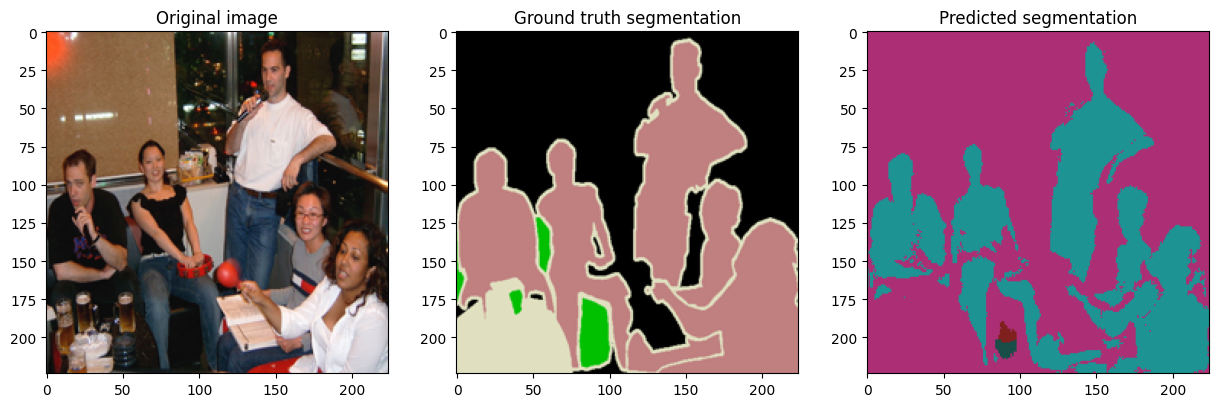

In [36]:
def create_color_index(num_classes):
    np.random.seed(0)  # 결과 재현성을 위해 시드 고정
    color_map = {}
    for i in range(num_classes):
        color_map[i] = np.random.randint(0, 256, size=(3,)).tolist()
    return color_map

# 예: 3개의 클래스를 가정
num_classes = 3
COLOR_2_INDEX = create_color_index(num_classes)


import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 모델 평가 모드로 전환
model.eval()

# 데이터셋에서 시각화할 이미지의 인덱스 설정
idx = 100
x, _ = train_dataset[idx]  # 원본 이미지 로드
y, _ = train_dataset.load_imgs(idx)  # 원본 이미지 로드 (정확히 어떤 용도로 쓰이는지 설명이 부족함)
gt = train_dataset.segmentation_imgs[idx]  # Ground truth segmentation 이미지 경로
gt = Image.open(gt).convert("RGB")  # Ground truth를 RGB 이미지로 변환

# 모델의 입력으로 사용하기 위해 이미지 크기 조정 및 차원 추가
x = x.unsqueeze(0)
y_hat = model(x)  # 모델로부터 예측 결과 생성
y_hat = torch.argmax(y_hat, dim=1)[0, :, :]  # 클래스별 예측값 중 가장 높은 값을 선택
y_hat = y_hat.detach().cpu().numpy()  # CPU로 이동 및 numpy 배열로 변환

# Ground truth 이미지를 모델의 출력 크기(img_size)로 조정
gt = gt.resize((img_size, img_size))
gt = np.array(gt)

# 클래스별 색상 맵 생성
num_classes = y_hat.max() + 1  # 예측된 클래스의 최대 값에 기반하여 클래스 수 확인
COLOR_2_INDEX = create_color_index(num_classes)

# 예측된 세그멘테이션 결과를 RGB 컬러로 변환할 빈 배열 생성
y_hat_mask = np.zeros((img_size, img_size, 3))

# 예측 결과를 RGB 색상으로 매핑
for i in range(img_size):
    for j in range(img_size):
        y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]

# 결과를 정수형으로 변환
y_hat_mask = y_hat_mask.astype(int)

# 시각화
plt.rcParams['figure.figsize'] = 15, 15

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.title("Original image")

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title("Ground truth segmentation")

plt.subplot(1, 3, 3)
plt.imshow(y_hat_mask)
plt.title("Predicted segmentation")

plt.show()

In [34]:
print(np.unique(y_hat))

[0]
